# Практическое задание 2

**Построение графа друзей из VK**

Создадим класс пользователя ВК (вершины графа). Пользователь задается двумя параметрами:

- VK ID
- Имя (только для друзей уровня 0, т.к. остальных хранить экономически невыгодно)
- Список друзей (их VK ID)

In [51]:
import json

class vk_user:
    def __init__(self, vk_id, name, friends):
        self.vk_id = vk_id
        self.name = name
        self.friends = friends

    def to_dict(self):
        return {
            'vk_id': self.vk_id,
            'name': self.name,
            'friends': self.friends
        }

    @staticmethod
    def from_dict(data):
        return vk_user(vk_id=data['vk_id'], name=data['name'], friends=data['friends'])
    

def save_people_to_json_file(usrs, filename):
    with open(filename, 'w') as file:
        json.dump([u.to_dict() for u in usrs], file)


def load_people_from_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        return [vk_user.from_dict(p) for p in data]

Создадим список "корневых" пользователей (то есть друзей глубины 0):

In [43]:
import pandas as pd

users = []

df = pd.read_csv("students.csv")
df.columns = ["full_name", "link", "id"]
df = df.dropna()
df['id'] = df['id'].astype(int).astype(str)
df.head(10)

for index, row in df.iterrows():
    users.append(vk_user(row["id"], row["full_name"], None))

По данному списку пройдемся дважды: в первый раз будут определены друзья для корневых пользователей, во второй раз - друзья их друзей.

В нем учтены два ограничения:
- Для каждого пользователя число друзей ограничено сотней
- Для друзей второго уровня учитываются только пользователи, найденные на первом этапе

In [44]:
import requests

deep = 2
MAX_FRIENDS_COUNT = 100
for d in range(deep):
    new_users = []
    for user in users:
        print(f"User with id = {user.vk_id} > ", end="")
        if user.friends == None:
            print("Fetching... > ", end="")
            url = f'https://api.vk.com/method/friends.get?user_id={user.vk_id}&v=5.199'
            response = requests.get(url)
            if 'response' not in response.json():
                print("Profile is private", end="\n")
                continue
            friends = response.json()['response']['items']
            found = 0
            added = 0
            for f in range(len(friends)):
                friend = friends[f]
                if f >= MAX_FRIENDS_COUNT:
                    break
                if d != 1 or any(person.vk_id == friend for person in users):
                    if user.friends == None:
                        user.friends = []
                    user.friends.append(friend)
                    found += 1
                    if all(person.vk_id != friend for person in users):
                        new_users.append(vk_user(friend, None, None))
                        added += 1
            print(f"Found {found}, added {added} friends of {100 if len(friends) > 100 else len(friends)}", end="\n")
        else:
            print("Already processed", end="\n")
    users.extend(new_users)


User with id = 172350665 > Fetching... > Found 100, added 100 friends of 100
User with id = 229180632 > Fetching... > Found 49, added 49 friends of 49
User with id = 145195585 > Fetching... > Found 100, added 100 friends of 100
User with id = 193887357 > Fetching... > Found 100, added 100 friends of 100
User with id = 386272361 > Fetching... > Found 76, added 76 friends of 76
User with id = 204720239 > Fetching... > Found 100, added 100 friends of 100
User with id = 162225997 > Fetching... > Found 87, added 87 friends of 87
User with id = 860446539 > Fetching... > Found 10, added 10 friends of 10
User with id = 472133870 > Fetching... > Found 100, added 100 friends of 100
User with id = 195614586 > Fetching... > Found 100, added 100 friends of 100
User with id = 825545292 > Fetching... > Found 18, added 18 friends of 18
User with id = 750743366 > Fetching... > Found 19, added 19 friends of 19
User with id = 637593527 > Fetching... > Profile is private
User with id = 299106540 > Fetchin

Поскольку накладно каждый раз обращаться к VK API, данные будут выгружены один раз и скомпанованы в JSON-файл.

In [59]:
save_people_to_json_file(users, "friendships.json")

In [58]:
users = load_people_from_json_file('friendships.json')

In [119]:
import matplotlib.pyplot as plt
import networkx as nx
import random

G = nx.Graph()

for user in users:
    G.add_node(user.vk_id)

for user in users:
    if user.friends != None:
        for friend_id in user.friends:
            if G.has_edge(user.vk_id, friend_id):
                continue
            G.add_edge(user.vk_id, friend_id)

red_nodes = [node for node in list(G.nodes()) if all(person.vk_id != node or person.name is not None for person in users)]
other_nodes = list(set(G.nodes()) - set(red_nodes))
lightblue_nodes = list(node for node in other_nodes if all(person.vk_id != node or person.friends is None or len(person.friends) < 2 for person in users))
other_nodes = list(set(other_nodes) - set(lightblue_nodes))
skyblue_nodes = list(node for node in other_nodes if all(person.vk_id != node or len(person.friends) < 10 for person in users))
other_nodes = list(set(other_nodes) - set(skyblue_nodes))
cornflowerblue_nodes = list(node for node in other_nodes if all(person.vk_id != node or len(person.friends) < 30 for person in users))
other_nodes = list(set(other_nodes) - set(cornflowerblue_nodes))
blue_nodes = list(node for node in other_nodes if all(person.vk_id != node or len(person.friends) < 50 for person in users))
darkblue_nodes = list(set(other_nodes) - set(blue_nodes))

edge_colors = ['lightgray', 'gray', 'darkgray', 'black']
random_edge_colors = [random.choice(edge_colors) for _ in range(len(G.edges()))]

print(f"Количество узлов: {len(G.nodes())}")
print(f"Количество рёбер: {len(G.edges())}")

Количество узлов: 1976
Количество рёбер: 11393


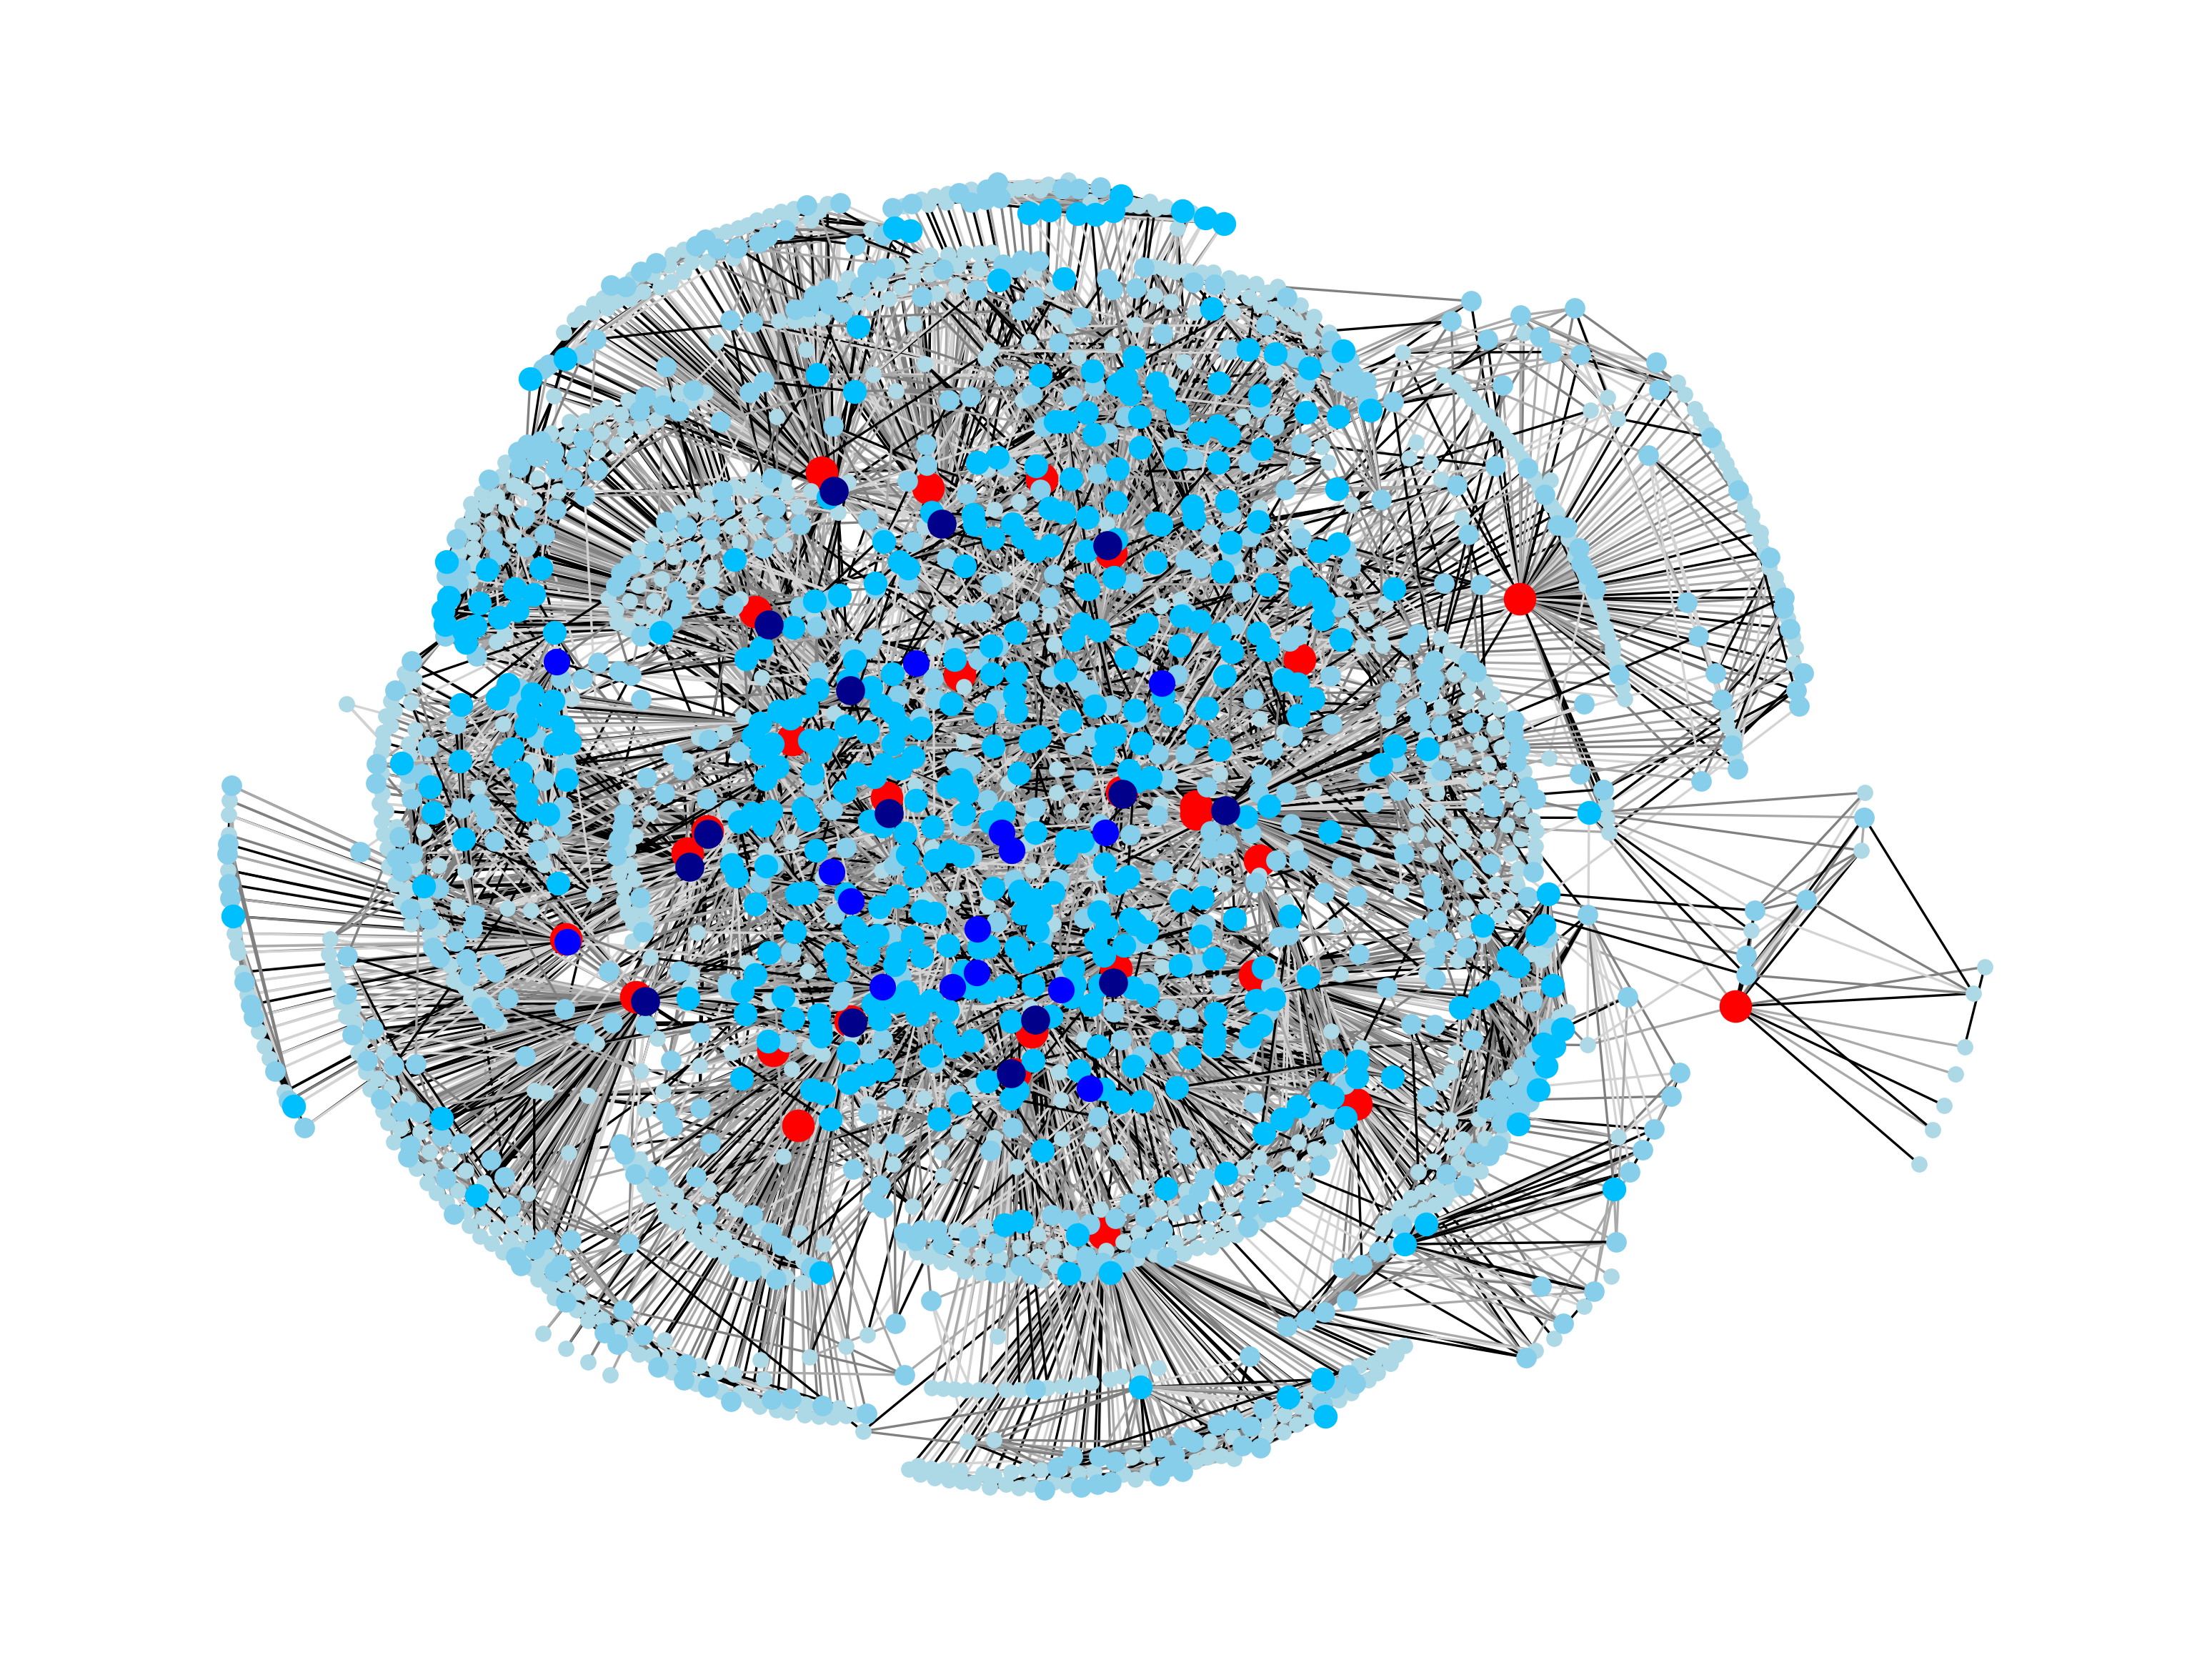

<Figure size 9000x7200 with 0 Axes>

In [121]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=red_nodes, node_color='red', node_size=20)
nx.draw_networkx_nodes(G, pos, nodelist=lightblue_nodes, node_color='lightblue', node_size=3)
nx.draw_networkx_nodes(G, pos, nodelist=skyblue_nodes, node_color='skyblue', node_size=6)
nx.draw_networkx_nodes(G, pos, nodelist=cornflowerblue_nodes, node_color='deepskyblue', node_size=9)
nx.draw_networkx_nodes(G, pos, nodelist=blue_nodes, node_color='blue', node_size=12)
nx.draw_networkx_nodes(G, pos, nodelist=darkblue_nodes, node_color='darkblue', node_size=15)
nx.draw_networkx_edges(G, pos, edge_color=random_edge_colors, width=0.4)

plt.axis('off')
plt.figure(figsize=(15, 12))
plt.rcParams.update({'figure.dpi': 600})
plt.savefig("graph.png", dpi=600)
plt.show()

**Центральность в графе**

Следующим шагом определим центральную вершину графа по разным индексам.

In [127]:
closeness_centrality_users = sorted(list(nx.closeness_centrality(G).items()), key=lambda i: i[1], reverse=True)
betweenness_centrality_users = sorted(list(nx.betweenness_centrality(G).items()), key=lambda i: i[1], reverse=True)
eigenvector_centrality_users = sorted(list(nx.eigenvector_centrality(G).items()), key=lambda i: i[1], reverse=True)
degree_centrality_users = sorted(list(nx.degree_centrality(G).items()), key=lambda i: i[1], reverse=True)

def print_central_student(students, way):
    for ccu, metrica in students:
        for user in users:
            if user.vk_id == ccu and user.name is not None:
                print(f"Центральный студент в группе по {way}: {user.name} (центральность {metrica})")
                return
                
                

print_central_student(closeness_centrality_users, "близости")
print_central_student(betweenness_centrality_users, "посредничеству")
print_central_student(eigenvector_centrality_users, "собственному значению")
print_central_student(degree_centrality_users, "степени")

Центральный студент в группе по близости: Латынова Татьяна Алексеевна (центральность 0.35683616291517756)
Центральный студент в группе по посредничеству: Цыганков Никита Денисович (центральность 0.08366637856797503)
Центральный студент в группе по собственному значению: Латынова Татьяна Алексеевна (центральность 0.20245448242825964)
Центральный студент в группе по степени: Алабужев Даниил Андреевич (центральность 0.05063291139240507)


### Центральность по близости
Центральный студент по близости находится близко ко всем остальным студентам в сети. Это означает, что ему требуется меньше шагов (переписок, звонков и т.п.) для достижения любого другого студента в сети.

Пример: В сети студентов, где некоторые общаются только с близкими друзьями, а другие имеют широкий круг общения, студент, который общается с теми, кто, в свою очередь, общается со многими другими студентами, имеет высокую центральность по близости. Такой студент может быстрее распространять информацию или влиять на других.

### Центральность по посредничеству
Центральный студент по посредничеству часто оказывается на пути связи между двумя другими студентами. То есть многие другие студенты зависят от него, чтобы связаться друг с другом.

Пример: Если есть два друга, которые редко общаются друг с другом, но оба общаются с другим, третьим другом, то он является мостиком между ними. Он может контролировать поток информации между ними, потому что они чаще всего взаимодействуют через него.

### Центральность по собственному значению
Студент с высокой центральностью по собственному значению дружит с важными людьми. Важно не столько количество друзей, сколько качество связей: друзья друзей тоже важны.

Пример: Даже если у студента мало друзей, но его друзья сами являются популярными и влиятельными, то такой студент считается важным. Это похоже на концепцию "не важно, кого ты знаешь, а важно, кто знает тебя".

### Центральность по степени
Это самый простой показатель. Центральный студент по степени — тот, у которого больше всего друзей. Чем больше у студента связей, тем выше его степень центральности.

Пример: Студент с наибольшим количеством друзей в группе имеет наивысшую степень центральности. Такой человек может легко общаться с большинством людей и иметь большое влияние на группу.
